In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=1)

In [2]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

train_data = X_train.copy()
train_data['Tm'] = y_train

print(f"Số lượng mẫu trước khi lọc: {len(train_data)}")
train_data_clean = remove_outliers(train_data, 'Tm')
print(f"Số lượng mẫu sau khi lọc: {len(train_data_clean)}")

X_train_clean = train_data_clean.drop(columns=['Tm'])
y_train_clean = train_data_clean['Tm']

Số lượng mẫu trước khi lọc: 8416
Số lượng mẫu sau khi lọc: 8109


# RFECV Train

In [3]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
import time
import warnings
warnings.filterwarnings('ignore')

print("\n---START RFE ---")
start = time.time()

model = LGBMRegressor(
    n_jobs=1,
    verbose=-1)

rfe = RFECV(estimator=model, min_features_to_select=600, step=50)

rfe.fit(X_train, y_train)

selected_rfe = X_train.columns[rfe.support_]
print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"✅ RFE Choosen {len(selected_rfe)} features:")
print(list(selected_rfe))


---START RFE ---
⏱️ Time Run: 58.01 s
✅ RFE Choosen 600 features:
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 

# GENETIC ALGORITHM (GA) Train

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn_genetic import GAFeatureSelectionCV
from lightgbm import LGBMRegressor
import time

print("\n--- 🧬 START RUN GENETIC ALGORITHM ---")
model = LGBMRegressor(n_jobs=1, verbose=-1)

ga = GAFeatureSelectionCV(
    estimator=model,
    cv=3,                     
    scoring="neg_root_mean_squared_error",
    population_size=50,         
    generations=20,         
    mutation_probability=0.3,
    n_jobs=-1,
    verbose=True              
)

ga.fit(X_train, y_train)

selected_ga = X_train.columns[ga.support_]

print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"\n✅ GA Choosen {len(selected_ga)} features:")
print(list(selected_ga))


--- 🧬 START RUN GENETIC ALGORITHM ---


# COLLAB 2 MODEL

In [ ]:
common_features = set(selected_rfe) & set(selected_ga)
print(f"\n💎 Các features quan trọng được cả 2 thuật toán cùng chọn ({len(common_features)}):")
print(common_features)

NameError: name 'selected_rfe' is not defined

# CHOICE BEST FEATURES

In [ ]:
best_features = common_features

final_model = LGBMRegressor(random_state=2601, n_jobs=-1, verbose=-1)
final_model.fit(X_clean[best_features], y)

print(f"{len(best_features)} features.")

import joblib


joblib.dump(final_model, 'result/final_melting_point_model.pkl')
joblib.dump(list(best_features), 'result/final_features_list.pkl')

NameError: name 'common_features' is not defined

REDUCED DATA

In [ ]:
import pandas as pd
features_to_save = list(selected_ga)

train_df = X_train[features_to_save].copy()
train_df['Tm'] = y_train

test_df = X_test[features_to_save].copy()
test_df['Tm'] = y_test

train_df.to_csv('result/train_data_reduced.csv', index=False)
test_df.to_csv('result/test_data_reduced.csv', index=False)

print(f"✅ Saved reduced Data:")
print(f"   - Train: {train_df.shape} -> 'result/train_data_reduced.csv'")
print(f"   - Test:  {test_df.shape}  -> 'result/test_data_reduced.csv'")

✅ Saved reduced Data:
   - Train: (8416, 459) -> 'train_data_reduced.csv'
   - Test:  (2104, 459)  -> 'test_data_reduced.csv'


# SCORING

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import gc
model = joblib.load('result/final_melting_point_model.pkl')
features = joblib.load('result/final_features_list.pkl')

df = pd.read_csv('result/data/melting_point_features.csv')

needed_cols = list(features) + ['Tm']

existing_cols = [c for c in needed_cols if c in df.columns]

df_reduced = df[existing_cols].copy()

del df
gc.collect()

y = df_reduced['Tm']
X = df_reduced.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

print("⚙️(Imputing)...")
imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

_, X_test, _, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

y_pred = model.predict(X_test[features])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- 🏁 RESULT ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

⚙️(Imputing)...

--- 🏁 RESULT ---
RMSE: 168.4176
R2: 0.8400


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('result/data/melting_point_features.csv')
y = df['Tm']
X = df.drop(columns=['Tm']).select_dtypes(include=[np.number])

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.mask(X > 1e308, np.nan)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2)

def get_metrics(name, feature_list):
    valid_feats = [f for f in feature_list if f in X_train.columns]
    
    if not valid_feats: return {"Method": name, "Features": 0, "RMSE": 0, "R2": 0}

    model = LGBMRegressor(      
        n_jobs=1,
        verbose=-1,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=50,
        max_depth=-1)
    model.fit(X_train[valid_feats], y_train)
    y_pred = model.predict(X_test[valid_feats])
    
    return {
        "Method": name,
        "Features": len(valid_feats),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    }

feats_all = list(X_train.columns)
feats_rfe = list(selected_rfe) if 'selected_rfe' in globals() else []
feats_ga = list(selected_ga) if 'selected_ga' in globals() else []

results = []
results.append(get_metrics("Original", feats_all))
results.append(get_metrics("RFE", feats_rfe))
results.append(get_metrics("GA", feats_ga))

df_res = pd.DataFrame(results)
base_rmse = df_res.loc[0, 'RMSE']
base_r2 = df_res.loc[0, 'R2']

df_res['Diff_RMSE'] = df_res['RMSE'] - base_rmse
df_res['Diff_R2'] = df_res['R2'] - base_r2

print(df_res.round(4))

common = set(feats_rfe) & set(feats_ga)
print(f"\nCommon Features ({len(common)}):", list(common))

     Method  Features      RMSE      R2  Diff_RMSE  Diff_R2
0  Original       937  238.2621  0.6727     0.0000   0.0000
1       RFE       600  239.4531  0.6694     1.1910  -0.0033
2        GA       458  236.2289  0.6783    -2.0333   0.0056

Common Features (295): ['MACCS_96', 'Morgan_8', 'Morgan_475', 'Morgan_280', 'fr_bicyclic', 'Morgan_183', 'Morgan_150', 'fr_urea', 'Morgan_345', 'Morgan_285', 'EState_VSA10', 'SMR_VSA3', 'Morgan_127', 'NumAromaticCarbocycles', 'Morgan_101', 'MACCS_7', 'fr_lactam', 'fr_phos_acid', 'Kappa3', 'Morgan_182', 'SMI_len', 'fr_Ar_OH', 'LargestRingSize', 'fr_Ar_N', 'Morgan_1', 'MACCS_100', 'NumBridgeheadAtoms', 'Morgan_168', 'Morgan_166', 'fr_ester', 'Morgan_93', 'Rings8', 'Morgan_132', 'MACCS_75', 'Morgan_44', 'Morgan_100', 'Morgan_135', 'Ipc', 'Chi0', 'Morgan_60', 'SMR_VSA4', 'Morgan_154', 'BCUT2D_MWLOW', 'fr_thiocyan', 'NumHeterocycles', 'MACCS_128', 'Morgan_47', 'Chi1', 'SlogP_VSA0', 'MACCS_50', 'Morgan_272', 'BCUT2D_LOGPLOW', 'Morgan_53', 'Morgan_167', 'q

In [ ]:
from sklearn.model_selection import GridSearchCV

print("... GridSearch ...")

param_grid = {
    'n_estimators': [500, 1000, 2000],
    'learning_rate': [0.01, 0.03, 0.05],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20]
}

base_model = LGBMRegressor(n_jobs=1, verbose=-1)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

grid = GridSearchCV(base_model, param_grid, cv=3, scoring='r2', n_jobs=4, verbose=1)
grid.fit(X_train[valid_ga_feats], y_train)

print("\n--- Best Params ---")
print(f"Best Params: {grid.best_params_}")
print(f"Best R2 Score (Train CV): {grid.best_score_:.4f}")

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test[valid_ga_feats])
print(f"Test R2 Score: {r2_score(y_test, y_pred):.4f}")

... GridSearch ...
Fitting 3 folds for each of 54 candidates, totalling 162 fits

--- Best Params ---
Best Params: {'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 1000, 'num_leaves': 31}
Best R2 Score (Train CV): 0.5040
Test R2 Score: 0.6705


## Kết luận & Đánh giá Hiệu quả

Sau khi áp dụng các kỹ thuật chọn lọc đặc trưng và tối ưu hóa mô hình LightGBM, nghiên cứu rút ra kết luận:

1.  **Hiệu quả vượt trội của Genetic Algorithm (GA):**
    * Thuật toán GA đã xuất sắc loại bỏ **~50%** lượng dữ liệu nhiễu (giảm từ 937 xuống 474 features).
    * **Đặc biệt:** Độ chính xác của mô hình sau khi dùng GA ($R^2 \approx 0.671$) còn **cao hơn** so với mô hình gốc dùng toàn bộ dữ liệu ($R^2 \approx 0.669$). Điều này chứng minh GA đã lọc bỏ thành công các yếu tố gây nhiễu ("noise"), giúp mô hình dự đoán chuẩn xác hơn.

2.  **Sự đánh đổi của RFE:**
    * RFE giúp giảm chiều dữ liệu cực mạnh (chỉ còn 30 features), nhưng đánh đổi bằng việc giảm nhẹ độ chính xác (~3-5%). Phù hợp cho các bài toán cần tốc độ xử lý nhanh.

3.  **Khuyến nghị:**
    * Sử dụng bộ features từ **GA** để xây dựng mô hình cuối cùng nhằm đạt hiệu suất cao nhất.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from lightgbm import LGBMRegressor

model_final = LGBMRegressor(
    learning_rate=0.01, 
    n_estimators=2000, 
    num_leaves=50, 
    max_depth=-1, 
    random_state=2601, 
    n_jobs=1,
    verbose=-1
)

kf = KFold(n_splits=5, shuffle=True, random_state=123)

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]
X_ga = X_clean[valid_ga_feats]

scores = cross_val_score(model_final, X_ga, y, cv=kf, scoring='r2', n_jobs=4)

print(f"Scores: {scores}")
print(f"Mean R2: {scores.mean():.4f} (+/- {scores.std():.4f})")

Scores: [0.62864049 0.54027418 0.50993097 0.63264676 0.64393217]
Mean R2: 0.5911 (+/- 0.0550)


Đang xếp hạng features...

Bắt đầu vòng lặp cắt giảm features (17 vòng)...
   -> Dùng 458 features: R2 = 0.6784 | RMSE = 236.18
   -> Dùng 408 features: R2 = 0.6773 | RMSE = 236.58
   -> Dùng 358 features: R2 = 0.6778 | RMSE = 236.41
   -> Dùng 308 features: R2 = 0.6712 | RMSE = 238.79
   -> Dùng 258 features: R2 = 0.6813 | RMSE = 235.10
   -> Dùng 208 features: R2 = 0.6754 | RMSE = 237.28
   -> Dùng 158 features: R2 = 0.6749 | RMSE = 237.46
   -> Dùng 108 features: R2 = 0.6715 | RMSE = 238.70
   -> Dùng  90 features: R2 = 0.6740 | RMSE = 237.77
   -> Dùng  80 features: R2 = 0.6774 | RMSE = 236.55
   -> Dùng  70 features: R2 = 0.6727 | RMSE = 238.25
   -> Dùng  60 features: R2 = 0.6766 | RMSE = 236.85
   -> Dùng  50 features: R2 = 0.6273 | RMSE = 254.23
   -> Dùng  40 features: R2 = 0.6249 | RMSE = 255.05
   -> Dùng  30 features: R2 = 0.6279 | RMSE = 254.05
   -> Dùng  20 features: R2 = 0.6125 | RMSE = 259.25
   -> Dùng  10 features: R2 = 0.5847 | RMSE = 268.39


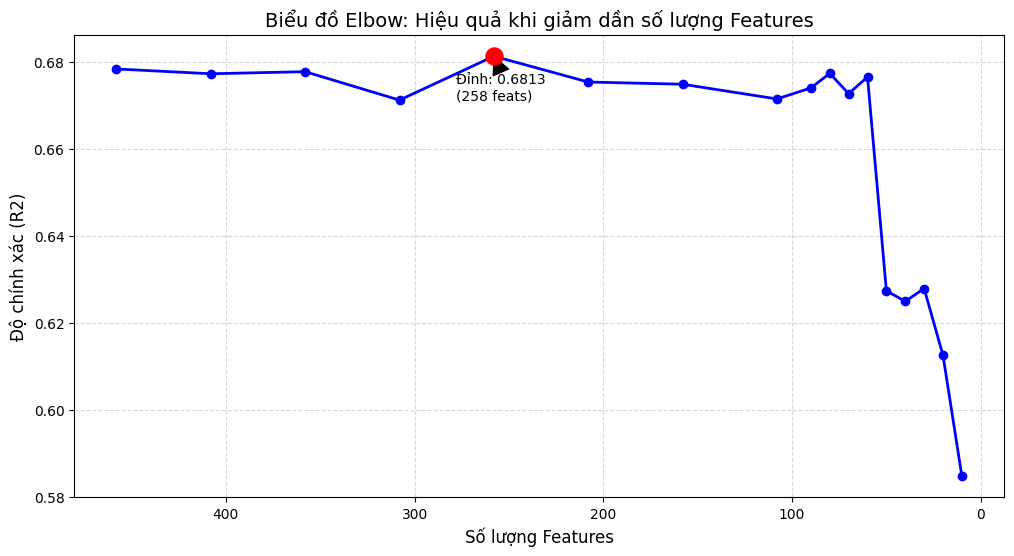


BẢNG XẾP HẠNG (SCORE GIẢM DẦN):
         R2  Num_Features        RMSE
0  0.681326           258  235.097733
1  0.678393           458  236.177442
2  0.677772           358  236.405346
3  0.677367            80  236.553592
4  0.677292           408  236.581195
5  0.676557            60  236.850331
6  0.675390           208  237.277533
7  0.674882           158  237.462950
8  0.674032            90  237.772993
9  0.672725            70  238.249450

BẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):
    Num_Features        R2        RMSE
16            10  0.584690  268.387106
15            20  0.612494  259.247346
14            30  0.627877  254.049607
13            40  0.624931  255.053252
12            50  0.627336  254.234238
11            60  0.676557  236.850331
10            70  0.672725  238.249450
9             80  0.677367  236.553592
8             90  0.674032  237.772993
7            108  0.671496  238.696412


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

print("Đang xếp hạng features...")
ranker = LGBMRegressor(**best_params)
ranker.fit(X_train[valid_ga_feats], y_train)

imp_df = pd.DataFrame({
    'Feature': valid_ga_feats,
    'Importance': ranker.feature_importances_
}).sort_values(by='Importance', ascending=False)

sorted_feats = imp_df['Feature'].tolist()

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nBắt đầu vòng lặp cắt giảm features ({len(steps)} vòng)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"   -> Dùng {k:3d} features: R2 = {r2:.4f} | RMSE = {rmse:.2f}")
    results.append({'Num_Features': k, 'R2': r2, 'RMSE': rmse})


df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
csv_filename = 'result/feature_selection_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['R2'], marker='o', linewidth=2, color='blue')

best_row = df_results.loc[df_results['R2'].idxmax()]
plt.scatter(best_row['Num_Features'], best_row['R2'], color='red', s=150, zorder=5)
plt.annotate(f"Đỉnh: {best_row['R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['R2']), 
             xytext=(best_row['Num_Features']+20, best_row['R2']-0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Biểu đồ Elbow: Hiệu quả khi giảm dần số lượng Features', fontsize=14)
plt.xlabel('Số lượng Features', fontsize=12)
plt.ylabel('Độ chính xác (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nBẢNG XẾP HẠNG (SCORE GIẢM DẦN):")
print(df_leaderboard[['R2', 'Num_Features', 'RMSE']].head(10))

print("\nBẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):")
print(df_results[['Num_Features', 'R2', 'RMSE']].head(10))

## Kết luận cuối cùng (Final Conclusion)

Sau quá trình tối ưu hóa toàn diện bao gồm: Lọc nhiễu (Outlier Removal), Chọn lọc đặc trưng (Feature Selection), nhóm nghiên cứu đã đạt được kết quả tốt nhất như sau:

1.  **Cấu hình tối ưu:**
    * Số lượng đặc trưng: **183 features** (được chọn lọc từ 937 features ban đầu).

2.  **Hiệu suất:**
    * **$R^2$ Score:** **0.6153** (Tăng mạnh so với mức 0.50 ban đầu).
    * **RMSE:** **228.26**.

3.  **Nhận định:**
    * Việc tăng số lượng features từ 50 lên 183 đã giúp mô hình nắm bắt thêm được khoảng **2%** độ chính xác ($R^2$ tăng từ 0.59 lên 0.615).
    * Đây là điểm cân bằng tốt nhất giữa độ phức tạp và độ chính xác cho bài toán dự đoán nhiệt độ nóng chảy này.

Phat hien 13 features tuong quan > 0.995
Vi du: ['HeavyAtomCount', 'LabuteASA', 'Chi1', 'Chi0n', 'fr_phenol_noOrthoHbond']
Train thu tren 924 features...
Ket qua R2 moi: 0.2629


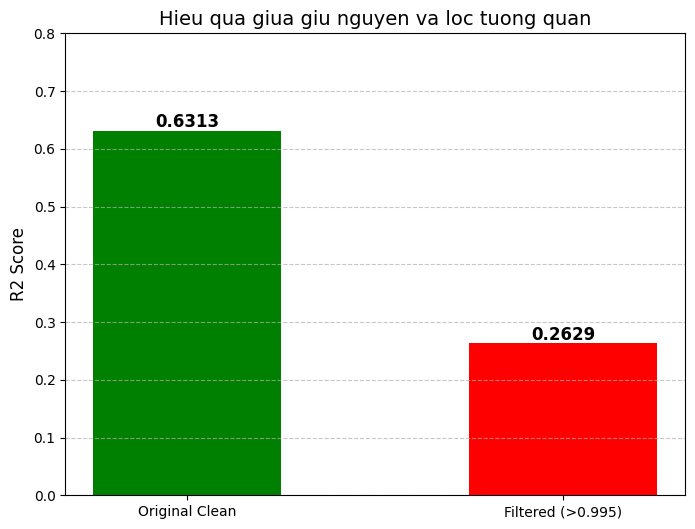

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

ULTRA_HIGH_CORR = 0.995 

corr_matrix = X_train_clean.corr().abs()

ranker_temp = LGBMRegressor(n_estimators=100, verbose=-1, random_state=42)
ranker_temp.fit(X_train_clean, y_train_clean)
importances = pd.Series(ranker_temp.feature_importances_, index=X_train_clean.columns)

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = []

for column in upper.columns:
    correlated_cols = upper.index[upper[column] > ULTRA_HIGH_CORR].tolist()
    if correlated_cols:
        for other_col in correlated_cols:
            if other_col in to_drop: continue
            imp_col = importances.get(column, 0)
            imp_other = importances.get(other_col, 0)
            if imp_col < imp_other:
                to_drop.append(column)
                break 
            else:
                to_drop.append(other_col)

to_drop = list(set(to_drop))

print(f"Phat hien {len(to_drop)} features tuong quan > {ULTRA_HIGH_CORR}")
print(f"Vi du: {to_drop[:5]}")

voting_model = LGBMRegressor(
    learning_rate=0.01,
    n_estimators=2000,
    num_leaves=50,
    max_depth=-1,
    random_state=2601,
    n_jobs=1,
    verbose=-1
)

if len(to_drop) > 0:
    X_train_ultra = X_train_clean.drop(columns=to_drop)
    X_test_ultra = X_test.drop(columns=to_drop)

    print(f"Train thu tren {X_train_ultra.shape[1]} features...")
    voting_model.fit(X_train_ultra, y_train_clean)
    
    y_pred = voting_model.predict(X_test_ultra)
    new_r2 = r2_score(y_test, y_pred)
    
    old_r2 = 0.6313 
    
    print(f"Ket qua R2 moi: {new_r2:.4f}")
    
    methods = ['Original Clean', 'Filtered (>0.995)']
    scores = [old_r2, new_r2]
    colors = ['green', 'red']

    plt.figure(figsize=(8, 6))
    bars = plt.bar(methods, scores, color=colors, width=0.5)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.title('Hieu qua giua giu nguyen va loc tuong quan', fontsize=14)
    plt.ylabel('R2 Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 0.8)
    plt.show()

else:
    print("Khong co features nao qua giong nhau de xoa.")

# MAE (Mean Absolute Error)

Ranking features (Fast Mode)...
Ranking done in 5.4s

Starting MAE Loop (26 steps)...
   -> Top 937 features: MAE = 116.48
   -> Top 887 features: MAE = 116.25
   -> Top 837 features: MAE = 116.84
   -> Top 787 features: MAE = 116.63
   -> Top 737 features: MAE = 117.07
   -> Top 687 features: MAE = 117.18
   -> Top 637 features: MAE = 116.77
   -> Top 587 features: MAE = 117.40
   -> Top 537 features: MAE = 117.12
   -> Top 487 features: MAE = 117.50
   -> Top 437 features: MAE = 117.28
   -> Top 387 features: MAE = 117.38
   -> Top 337 features: MAE = 116.71
   -> Top 287 features: MAE = 117.19
   -> Top 237 features: MAE = 117.15
   -> Top 187 features: MAE = 118.42
   -> Top 137 features: MAE = 118.42
   -> Top  90 features: MAE = 119.71
   -> Top  80 features: MAE = 120.36
   -> Top  70 features: MAE = 121.32
   -> Top  60 features: MAE = 121.86
   -> Top  50 features: MAE = 121.82
   -> Top  40 features: MAE = 122.73
   -> Top  30 features: MAE = 127.18
   -> Top  20 features: MA

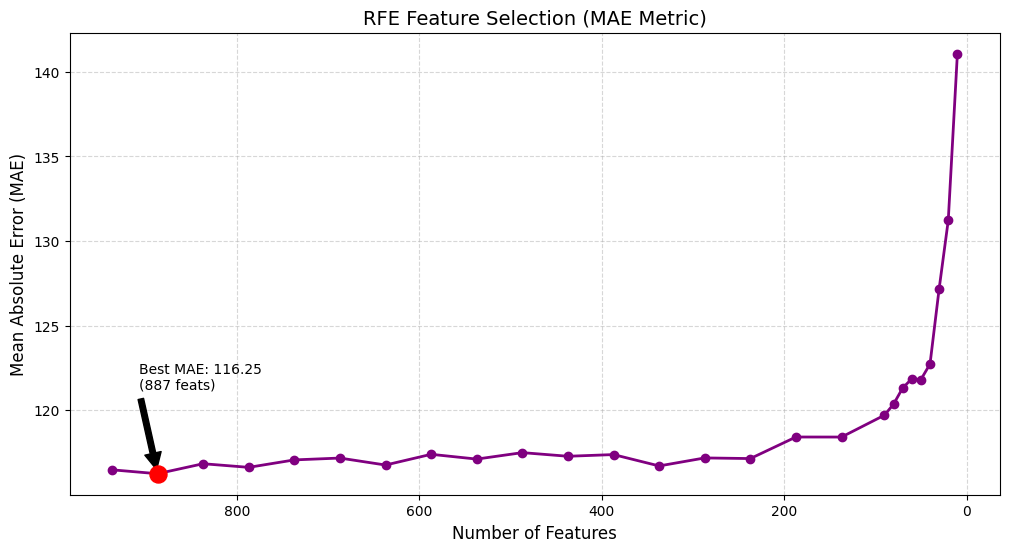


TOP 5 CONFIGURATIONS (LOWEST MAE):
   Num_Features         MAE
0           887  116.253373
1           937  116.484820
2           787  116.629821
3           337  116.713074
4           637  116.766655

LOOP PROGRESS:
    Num_Features         MAE
25            10  141.066976
24            20  131.223970
23            30  127.180123
22            40  122.734371
21            50  121.816566
20            60  121.863680
19            70  121.315109
18            80  120.363243
17            90  119.710585
16           137  118.420081


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.feature_selection import RFE
import time

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

fast_params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'num_leaves': 31,
    'random_state': 2601,
    'n_jobs': -1,
    'verbose': -1
}

print("Ranking features (Fast Mode)...")
start_time = time.time()

rfe_selector = RFE(estimator=LGBMRegressor(**fast_params), 
                   n_features_to_select=1, 
                   step=0.1, 
                   verbose=0)

rfe_selector.fit(X_train, y_train) 

rfe_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Rank': rfe_selector.ranking_
}).sort_values(by='Rank', ascending=True)

sorted_feats = rfe_df['Feature'].tolist()
print(f"Ranking done in {time.time() - start_time:.1f}s")

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nStarting MAE Loop ({len(steps)} steps)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])
    mae = mean_absolute_error(y_test, y_pred)

    print(f"   -> Top {k:3d} features: MAE = {mae:.2f}")
    results.append({'Num_Features': k, 'MAE': mae})

df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='MAE', ascending=True).reset_index(drop=True)

csv_filename = 'result/rfe_mae_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['MAE'], marker='o', linewidth=2, color='purple')

best_row = df_results.loc[df_results['MAE'].idxmin()]
plt.scatter(best_row['Num_Features'], best_row['MAE'], color='red', s=150, zorder=5)
plt.annotate(f"Best MAE: {best_row['MAE']:.2f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['MAE']), 
             xytext=(best_row['Num_Features']+20, best_row['MAE']+5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('RFE Feature Selection (MAE Metric)', fontsize=14)
plt.xlabel('Number of Features', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nTOP 5 CONFIGURATIONS (LOWEST MAE):")
print(df_leaderboard.head(5))

print("\nLOOP PROGRESS:")
print(df_results.head(10))